# **Sentiment classification - close to the state of the art**

Submitted By: Shaikh Muhammad Asjad Raza


This Notebook contains:
1. Logistic Regression
2. LSTM with GloVe Embeddding
3. FastText Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import os

# **Load the data.**

In [ ]:
# read the data
data = pd.read_pickle('/content/drive/MyDrive/data/data')

In [ ]:
# Do the splitting
train_df = data.iloc[0:25000, 1]
y_train = data.iloc[0:25000, 0]
valid_df = data.iloc[25000:, 1]
y_valid = data.iloc[25000:, 0]
print(train_df.shape, valid_df.shape)

(25000,) (25000,)


# **Models**

### **TFIDF for Logistic Regression**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
# Hyperparameters tuned according to the 
# creating bigrams
tfidf = TfidfVectorizer(ngram_range = (1,4), sublinear_tf=True, max_features = 35000)

In [ ]:
train_tfidf = tfidf.fit_transform(train_df)
valid_tfidf = tfidf.transform(valid_df)

In [ ]:
vocab = tfidf.get_feature_names()
print("Vocabulary length:", len(vocab))

Vocabulary length: 35000


In [ ]:
print('Train dim:',train_tfidf.shape, 'valid dim:', valid_tfidf.shape)

Train dim: (25000, 35000) valid dim: (25000, 35000)


## **Logistic Regression**

In [ ]:
# import necessary libraries
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score

In [ ]:
# define stratified  k-fold Cross Validation
kfold = StratifiedKFold(n_splits = 10, shuffle=True)

In [ ]:
lr = LogisticRegression(random_state = 19,  max_iter=200)

# Hyperparameters choosen based on optimal performance
lr_params = {
    'penalty':['l2', 'l1'],
    'C':[1],
    'class_weight':[{1:1}],
    'solver': ['liblinear']
    }

# Do the best parameter search using GridSerchCV
lr_CV = GridSearchCV(lr, param_grid = [lr_params], cv = kfold, scoring = 'accuracy', n_jobs = 1, verbose = 1)
lr_CV.fit(train_tfidf, y_train)
print(lr_CV.best_params_)
print(lr_CV.best_estimator_)

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   11.2s finished


{'C': 1, 'class_weight': {1: 1}, 'penalty': 'l2', 'solver': 'liblinear'}
LogisticRegression(C=1, class_weight={1: 1}, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=19, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)


In [ ]:
# get the best score on train_tfidf
print('Accuracy on Train set: ' + str(lr_CV.best_score_))

Accuracy on Train set: 0.8855999999999999


In [ ]:
# predict and check accuracy on valid_tfidf
y_pred_valid = lr_CV.predict(valid_tfidf)
print('Accuracy on Validation set: ' + str(accuracy_score(y_valid, y_pred_valid)))

Accuracy on Validation set: 0.88116


Observations:
1. To my surprise, Logistic Regression turned out to be slightly better than LSTM with Keras/Golve Embedding.
2. There was 1% increase in the validation accuracy when sublinear_tf was set to True. 
3. Reason could be that with High dimentional data Logictic Regression performs better because Model complexity can be controlled (less overfitting) whereas in case of LSTM model complexity is difficult to control which leads to overfitting. 

## **LSTM with Global Vectors for Word Representation (GloVe) Embedding**

Using the following pretrained version:

Wikipedia 2014 + Gigaword 5 (6B tokens, 400K vocab, uncased, 200 dimentional vectors)

In [ ]:
# Import the necessary libraries
from tensorflow.keras.layers import LSTM, Input, Embedding, Dense, Dropout, SpatialDropout1D, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as be
from tensorflow.keras.optimizers import Adadelta, Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.initializers import glorot_normal
from tensorflow.keras.models import load_model
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
import tensorflow as tf

In [ ]:
# according to performance
max_seq_length = 200
max_words = 32000

In [ ]:
# This function will Tokenize the data
# Putting indexes of words in vocab in training/validation data to generate sequence of numbers
# Then pad the sequence so that they are of same length as expected by LSTM

def tokenize_padding_seq(train_df, valid_df, max_words, max_seq_length):
   
    tokenizer = Tokenizer(num_words=max_words, split=' ', lower=True)

    tokenizer.fit_on_texts(train_df)
    X_train = tokenizer.texts_to_sequences(train_df)
    X_valid  = tokenizer.texts_to_sequences(valid_df)

    X_train = sequence.pad_sequences(X_train, maxlen=max_seq_length, padding='post', truncating='post')
    X_valid  = sequence.pad_sequences(X_valid,  maxlen=max_seq_length, padding='post', truncating='post')
    
    # Tokeneizer gives more tokens then that of the actual vocab size
    word_index = tokenizer.word_index
    print('Found %s unique tokens.' % len(word_index))
    return X_train, y_train, X_valid, y_valid, word_index

In [ ]:
# call the tokenize_padding_seq 
X_train, y_train, X_valid, y_valid, word_index = tokenize_padding_seq(train_df, valid_df, max_words=max_words, max_seq_length=max_seq_length)

Found 31594 unique tokens.


In [ ]:
X_train.shape

(25000, 200)

#### **Generate Embedding matrix**

In [ ]:
# load the file and create embedding index

# folder where glove embeddings are availabe
glove_dir = '/content/drive/MyDrive/glove.6B' 

#create a dictionary for embedding vectors and words
embedding_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding='utf8')

# line by line read the file
for line in f:
  values = line.split()
  # in our dictionary the key would be a word
  # word is the 0th element in the file
  word = values[0] 
  # get the corresponding vector  
  coefs = np.asarray(values[1:], dtype='float32')
  # put word and vector in the dictionary
  embedding_index[word] = coefs
# once done close the file
f.close()
print('Found %s word vectors.' %len(embedding_index))

Found 400000 word vectors.


In [ ]:
# As i am using 200 dimentional pretrained vector
embedding_size = 200

# create an array embeddings full of zeros with the following dimention
# in the for loop i will populate it
embedding_matrix = np.zeros((max_words, embedding_size))

# for every word in vocab 
for word, i in word_index.items():
  # only consider max_words
  if i < max_words:
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector 

In [ ]:
embedding_matrix.shape

(32000, 200)

#### **Model**

In [ ]:
# Define # of LSTM units
LSTM_size = 64
# Define dropout rate
dropout_rate = 0.4

In [ ]:
# reset the graph
be.clear_session()
tf.compat.v1.reset_default_graph()


# Input layer 
inputs = Input(shape = (max_seq_length, ))

# Embedding Layer
# Trainable = False
embedding_layer = Embedding(max_words, embedding_size, input_length=max_seq_length, weights=[embedding_matrix], mask_zero=True, trainable=False)(inputs)

# LSTM Layer
LSTM_1 = LSTM(LSTM_size, kernel_initializer=glorot_normal(seed=19), return_sequences=False)(embedding_layer)

# Dropout
Dropout_1 = Dropout(dropout_rate, seed=19)(LSTM_1)

# Output layer
# Binary Classification problem therefore 1 unit & sigmoid activation
predictions = Dense(1, activation = 'sigmoid')(Dropout_1)

# Initilize the Model
model = Model(inputs=inputs, outputs=predictions)

# Get the model summay
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 200, 200)          6400000   
_________________________________________________________________
lstm (LSTM)                  (None, 64)                67840     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 6,467,905
Trainable params: 67,905
Non-trainable params: 6,400,000
_________________________________________________________________


#### **Loss and Optimization**

In [ ]:
# Loss, since its a binary classification problem
loss = 'binary_crossentropy'

# Optimizer
optimizer = Adam(learning_rate=0.0001) 
 
# Compilation
model.compile(loss=loss, optimizer= optimizer, metrics = ['accuracy'])

#### **Training**

In [ ]:
checkpoint_filepath = '/content/drive/MyDrive/checkpoint_lstm_glove/temp'

# Save the weights based on min validation loss. 
# even if model overfits i'll use this checkpoint to get the weights which had min valid loss.
model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, monitor='val_loss', mode='min', save_best_only=True)

# I will use the entire train data for training and use the test data (which i renamed 
# as valid data) for validation.

# Loads the weights (IF NEEDED)
#model.load_weights(checkpoint_filepath)
with tf.device('/gpu:0' and '/gpu:1'):
  history = model.fit(X_train, 
                      y_train,
                      epochs=20,
                      validation_data=(X_valid, y_valid),
                      batch_size=16,
                      verbose=1,
                      shuffle=True,
                      callbacks=[model_checkpoint_callback])

Epoch 1/20
1563/1563 [==============================] - 26s 16ms/step - loss: 0.5318 - accuracy: 0.7240 - val_loss: 0.4384 - val_accuracy: 0.7992
Epoch 2/20
1563/1563 [==============================] - 25s 16ms/step - loss: 0.4308 - accuracy: 0.8096 - val_loss: 0.4250 - val_accuracy: 0.8039
Epoch 3/20
1563/1563 [==============================] - 25s 16ms/step - loss: 0.4018 - accuracy: 0.8238 - val_loss: 0.3930 - val_accuracy: 0.8253
Epoch 4/20
1563/1563 [==============================] - 25s 16ms/step - loss: 0.3834 - accuracy: 0.8360 - val_loss: 0.3793 - val_accuracy: 0.8329
Epoch 5/20
1563/1563 [==============================] - 25s 16ms/step - loss: 0.3687 - accuracy: 0.8425 - val_loss: 0.3985 - val_accuracy: 0.8206
Epoch 6/20
1563/1563 [==============================] - 25s 16ms/step - loss: 0.3551 - accuracy: 0.8486 - val_loss: 0.3937 - val_accuracy: 0.8272
Epoch 7/20
1563/1563 [==============================] - 25s 16ms/step - loss: 0.3434 - accuracy: 0.8551 - val_loss: 0.3554 -

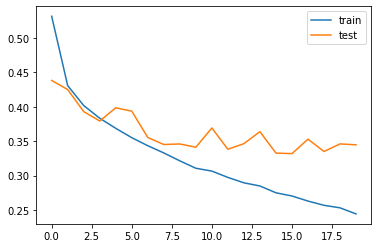

In [ ]:
# Visualize the loss since i have several epochs in this Model:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
model.load_weights(checkpoint_filepath)
scores = model.evaluate(X_valid, y_valid, verbose=1)

782/782 [==============================] - 5s 6ms/step - loss: 0.3319 - accuracy: 0.8616


Observations:
1. Increasing the number of units/layers was only resulting in overfitting and dropout was not helping either.
2. In my opinion, given the data preprocessing that i have done, the Model has reached the generalization capasity. 
3. Or, Getting more training data may help in this case (Since I have used 50% train and 50% Valid).  

## **FastText Model**

In [ ]:
# Download fasttext Model
!wget https://github.com/facebookresearch/fastText/archive/v0.9.2.zip

--2020-12-04 00:57:13--  https://github.com/facebookresearch/fastText/archive/v0.9.2.zip
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/facebookresearch/fastText/zip/v0.9.2 [following]
--2020-12-04 00:57:13--  https://codeload.github.com/facebookresearch/fastText/zip/v0.9.2
Resolving codeload.github.com (codeload.github.com)... 192.30.255.120
Connecting to codeload.github.com (codeload.github.com)|192.30.255.120|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘v0.9.2.zip.2’

v0.9.2.zip.2            [  <=>               ]   4.17M  15.2MB/s    in 0.3s    

2020-12-04 00:57:14 (15.2 MB/s) - ‘v0.9.2.zip.2’ saved [4369852]



In [ ]:
# unzip the files
#!unzip v0.9.2.zip

In [ ]:
# Move to the fastText directory
os.chdir('fastText-0.9.2')
!make

c++ -pthread -std=c++11 -march=native -O3 -funroll-loops -DNDEBUG -c src/args.cc
c++ -pthread -std=c++11 -march=native -O3 -funroll-loops -DNDEBUG -c src/autotune.cc
c++ -pthread -std=c++11 -march=native -O3 -funroll-loops -DNDEBUG -c src/matrix.cc
c++ -pthread -std=c++11 -march=native -O3 -funroll-loops -DNDEBUG -c src/dictionary.cc
c++ -pthread -std=c++11 -march=native -O3 -funroll-loops -DNDEBUG -c src/loss.cc
c++ -pthread -std=c++11 -march=native -O3 -funroll-loops -DNDEBUG -c src/productquantizer.cc
c++ -pthread -std=c++11 -march=native -O3 -funroll-loops -DNDEBUG -c src/densematrix.cc
c++ -pthread -std=c++11 -march=native -O3 -funroll-loops -DNDEBUG -c src/quantmatrix.cc
c++ -pthread -std=c++11 -march=native -O3 -funroll-loops -DNDEBUG -c src/vector.cc
c++ -pthread -std=c++11 -march=native -O3 -funroll-loops -DNDEBUG -c src/model.cc
c++ -pthread -std=c++11 -march=native -O3 -funroll-loops -DNDEBUG -c src/utils.cc
c++ -pthread -std=c++11 -march=native -O3 -funroll-loops -DNDEBUG -

In [ ]:
# install FastText Model
!pip install fasttext

#### **Data Preparation**

According to FastText documentation: 

Each line of the text file contains a list of labels, followed by the corresponding document. All the labels start by the __label__ prefix, which is how fastText recognize what is a label or what is a word. The model is then trained to predict the labels given the word in the document.

In [ ]:
# get the data
data = pd.read_pickle('/content/drive/MyDrive/data/data')

In [ ]:
# splitting
train_df = data.iloc[0:25000, ]
valid_df = data.iloc[25000:, ]
print(train_df.shape, valid_df.shape)

(25000, 2) (25000, 2)


In [ ]:
import warnings
warnings.filterwarnings('ignore')

# convert the labels from float to positive and negative labels
train_df['label'] = train_df['label'].map({1.0: 'positive', 0.0: 'negative'})
valid_df['label'] = valid_df['label'].map({1.0: 'positive', 0.0: 'negative'})

All the labels start by the label prefix, which is how fastText recognize what is a label or what is a word. 

In [ ]:
import warnings
warnings.filterwarnings('ignore')

train_df['label'] = ['__label__' + str(l) for l in train_df['label']]
valid_df['label'] = ['__label__' + str(l) for l in valid_df['label']]

**For training the algorithm i have to specify the path as input. Input must be a filepath** 

In [ ]:
# dataframe to csv
train_df.to_csv(r'/content/drive/MyDrive/fast_text_data/train.txt', header=False, sep = ' ', index=False)
valid_df.to_csv(r'/content/drive/MyDrive/fast_text_data/test.txt', header=False, sep = ' ', index=False)

### **Model**

In [ ]:
# import the model
import fasttext

In [ ]:
# Training
model = fasttext.train_supervised(input="/content/drive/MyDrive/fast_text_data/train.txt", epoch=32, wordNgrams=3, verbose=1)

In [ ]:
# Testing
model.test('/content/drive/MyDrive/fast_text_data/test.txt')

(25000, 0.87192, 0.87192)

Python version of the implementation did not print training and validation verbose. I am now trying command line tool:

### **Model try 2**

In [ ]:
# Training
!./fasttext supervised -input '/content/drive/MyDrive/fast_text_data/train.txt' -output model_sentiment -epoch 30 -wordNgrams 3

Read 2M words
Number of words:  40214
Number of labels: 2
Progress: 100.0% words/sec/thread:  119414 lr:  0.000000 avg.loss:  0.092667 ETA:   0h 0m 0s


OUTPUT:  
(P@1) ----->  precision

(R@1) -----> recall  

In [ ]:
# Testing
!./fasttext test model_sentiment.bin '/content/drive/MyDrive/fast_text_data/test.txt'

N	25000
P@1	0.872
R@1	0.872


**Well Both are giving the same results. Lets try to predict a few sentences:**

In [ ]:
# Testing on actual reviews from imdb website (not from the test/valid/train set). 

Test_list = [
             # review 0: Actual user rating 10/10
             "This film is every definition of the word 'impeccable.' Scorcese's fantastic storytelling ability mixed with phenomenal acting from DiCaprio, Hill and the rest of the cast makes for an awesome combination. The film is never boring and gives you a glimpse into the life of a man who had everything in the world only to have it taken away.",
             # review 1: Actual user rating 10/10
             '"The Wolf of Wall Street" is infectiously entertaining. It is probably the funniest movie I have seen all year with witty dialogue, over the top characters, and filled with energy that bleeds off the screen. Between all the fun however,  there is also a story about addiction and how it can cause a downward spiral in your life whether it be drugs, money, or power.',
             # review 2: Actual user rating 10/10
             "For anyone who isn't much into cinema, I would recommend watching Django Unchained and you will fall in love with films forever.This film is a classic western full of drama, suspense and tension with a tremendously unpredictable plot but with a sense of realism taken into consideration.I believe it would be hard to dislike this masterpiece as it has it all: action, adventure and even a sense of romance and the occasional humour.",
             # review 3: Actual user rating 1/10
             "Critics are giving Tarantino way too much credit for saying anything meaningful in this film. His references to 60's spaghetti westerns or 70's black exploitation films don't go beyond cheesy film titles and the interpolation of icky songs on the sound track - the social relevance of these films could hardly matter to him; he doesn't have much to say about slavery, other than it was bad; his emotional palette ranges from revenge to more revenge - anything else is beyond him; his lengthy dialog scenes are becoming predictable -dull, too-cute. The only real difference between the films Tarantino is emulating and his film is a fetish for mixing violence with comedy. I can't help but think that Tarantino sees himself as a liberal-cool-auteur-artist; but it is pretty easy to see through what critics call his social 'deepening' as a recent tendency to patronize",
             # review 4: Actual user rating 1/10
             "This is nominated for best picture? You got to be kidding me. Where are the sweeping themes, the original ideas, the unique contribution to cinema? This is just a remake of a spaghetti western/blaxploitation movie, with the same old funky soundtrack, the same old movie homages, plot tricks, blood splatter, etc. It was fresh and original in Pulp Fiction, but half a dozen movies later, it is becoming formula. But, wait, I forgot, this is a savage indictment of slavery. Hahahaha. This is movie nerd Tarantino stealing other directors' ideas and painting the world in ludicrously simplistic black-and-white, in Technicolor, so that the bad guys are so detestable you'll cheer graphic violence and mass murder. This time it was slavers, last time it was Nazis, what cliché bad guys will be next? Terrorists? Vampires? In a musical homage? How long can this juvenile director keep spinning the same old blood-spattered revenge theme in a genre remake? This is not cutting edge cinema, folks. Using the N-word does not make you a daring film genius. Now if Quentin spent his multi-million budgets on a movie about, say, a father whose daughter was gunned down in a mass shooting, and goes on a killing spree at the NRA headquarters or a Hollywood studio, I'd be just as disgusted but at least I'd call him original. Well, no, it would be just more twisted cliché, like all Tarantino movies these days.",
             # review 5: Actual user rating 5/10
             "A bounty hunter helps a slave rescue his wife. Tarantino has a sick obsession with violence. In films like 'Pulp Fiction' and 'Inglorious Basterds,' the scripts are so interesting that one can overlook the blood-fest. Unfortunately, the script for this Western is so long and dreary that the repellent violence can't be ignored. The film actually gets off to a fairly engaging start, thanks to a gem of a performance from Waltz as dentist slash bounty hunter. Foxx is much less interesting as Django, a perpetually angry and arrogant slave. Things take a turn for the dreary when DiCaprio enters the picture as an evil slave owner. Soon thereafter the film runs out of steam but still rambles on for about an hour.",
             # review 6: Actual user rating 4/10
             "Perversely, this movie would actually have to be better for me to dislike it. As it is, it's just too boring to care about. Good cast and crew, likeable production values, no complaints there - but there's also no story, no believability, no suspense, no interest, no ANYTHING.",
             # review 7: Actual user rating 3/10 (The interesting one!)
             "Spielberg/ Decaprio/Hanks - just those three names alone are enticing enough to get viewers into cinemas to watch this film, based on true life events.I can't fault this film. It's entertaining, it's well performed and well directed (of course!), but it just didn't grab me in the same way my favourite films do. Perhaps I found it hard to root for a character who is clearly breaking the law, I don't know.I would recommend it though, because it's a pacy, fun film that is entertaining enough.",
             # review 8: Actual user rating 3/10 
             "I cannot believe what I am reading. Sorting reviews by most helpful, they are mostly giving the movie 10/10. Did we watch something different? This movie contains almost no character development. I seriously can't even remember their names by this point.Also, the cliches with the stories were plentiful. The CGI was overdone and the entire movie leaves the audience feeling detached from reality. Seriously, give this one a pass. By far the wort Jurassic movie.",
             # review 9: Actual user rating 5/10
             "Ever saw those monster movies on Syfy channel? You know, the ones with the 2 dimensional characters. That have poor dialogue and horrible special effects. Well that's Jurassic World, with exception of the sfx. Jurassic World looks expensive, has some fantastic shots but unfortunately nobody seemed to care about writing interesting characters or story lines. And if the characters are so badly written it's not surprisingly that the actor's deliver poor work. Yes, the movie has a few funny moments but the entire cast is uninteresting, shallow and predictable. Basically just like the storyline."
             ]

for i in range(len(Test_list)):
  print("'review %d' prediction:  " %i + str(model.predict(Test_list[i], k=1)))

'review 0' prediction:  (('__label__positive',), array([0.98248661]))
'review 1' prediction:  (('__label__positive',), array([0.98123014]))
'review 2' prediction:  (('__label__positive',), array([0.90841728]))
'review 3' prediction:  (('__label__negative',), array([0.80000019]))
'review 4' prediction:  (('__label__negative',), array([0.52201205]))
'review 5' prediction:  (('__label__negative',), array([0.81545871]))
'review 6' prediction:  (('__label__negative',), array([0.98961776]))
'review 7' prediction:  (('__label__positive',), array([0.89246422]))
'review 8' prediction:  (('__label__negative',), array([0.948093]))
'review 9' prediction:  (('__label__negative',), array([0.99948269]))


"review 0" prediction:  ('__label__positive',), array([**0.98248661**]) ---> means with 98% probability review 0 belongs to negative class.

Observations:
1. WordNgrams=3 really helped in improving the results.
2. Model tends to overfit after 30 epochs. 
3. Easy to implement and performs considerably good.